# Demo for solving the CSC problem for multiple input images

In [1]:
import numpy as np
import scipy.io as sio


import F2O.F2O_utils as F2O
import F2O.constants as f2oDef
from F2O.imgUtils.image_utils import ImgPlot, ImgRead

from F2O.fwOp.fwOperator import fwOp_f

from F2O.noise.noiseModels import noiseModels

from F2O.PG_freq import apg as fAPG


import multiprocessing
import pyfftw

pyfftw.config.NUM_THREADS = multiprocessing.cpu_count()
pyfftw.config.PLANNER_EFFORT = 'FFTW_MEASURE'


# If you get an error while loading the F2O, then
# 
# * Exit Jupyter
# * Go to the F2O root dir, and execute
#      export PYTHONPATH=$PYTHONPATH:`pwd`
# * Relaunch Jupyter
#

No module named 'pyopencl'. cl12 version by Christoph Gohlke for windows is recommended: https://www.lfd.uci.edu/~gohlke/pythonlibs/#pyopencl


## Read list of images, select noise model 


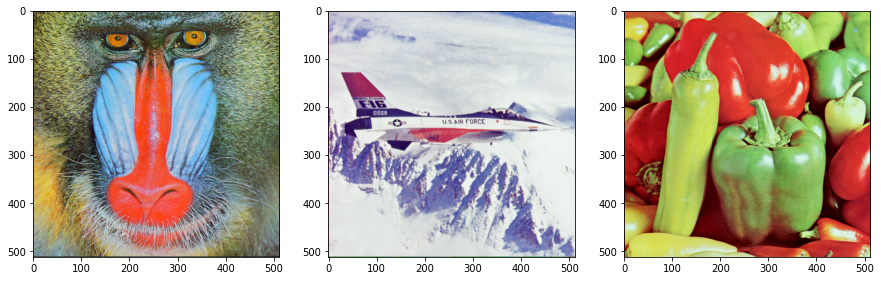

In [2]:
# -------------------
# --- Read images ---
# -------------------

import requests
from io import BytesIO

# Read images (images must be of the same size)
testImgs = ImgRead(enableJAX=False)

# Test images from the SIPI image database
fname = {0: requests.get('http://sipi.usc.edu/database/misc/5.2.10.tiff'),   # bridge (grayscale)
         1: requests.get('http://sipi.usc.edu/database/misc/boat.512.tiff'), # boat (grayscale)
         2: requests.get('http://sipi.usc.edu/database/misc/4.2.03.tiff'),   # mandrill (color)
         3: requests.get('http://sipi.usc.edu/database/misc/4.2.05.tiff'),   # airplane (color)
         4: requests.get('http://sipi.usc.edu/database/misc/4.2.07.tiff'),   # peppers (color)
        }


color=True

if color is False:    

   testImgs.list.append([BytesIO(fname.get(0).content),'g'])
   testImgs.list.append([BytesIO(fname.get(1).content),'g'])
      
else:

   testImgs.list.append([BytesIO(fname.get(2).content),'c'])
   testImgs.list.append([BytesIO(fname.get(3).content),'c'])
   testImgs.list.append([BytesIO(fname.get(4).content),'c'])
    
u = testImgs.readListImgs()                  # read list of images, normalize them between 0 and 1
                                             # u   : original image
                                             # obs : u corrupted with noise (depends on noiseModels)

        
pltImg  = ImgPlot()
pltImg.plotNImgs(u, len(u), None, 5)    



## Generate observed images

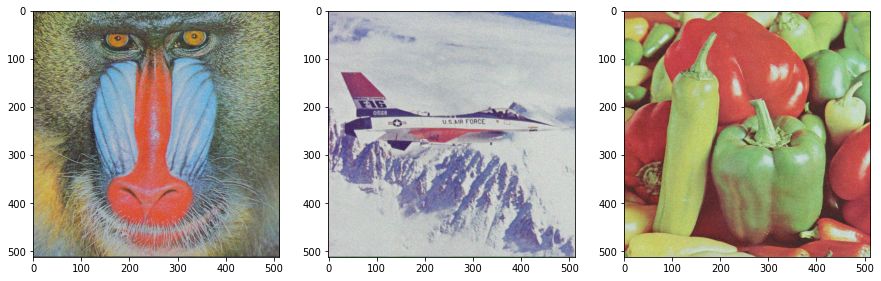

In [3]:
# --------------------------------------
# --- Set parameters for noise model ---
# --------------------------------------
    
noise = noiseModels(model=f2oDef.noise.Gaussian, sigma=0.05)
        
addNoise = noise.sel_NoiseModel()

z = addNoise(u)

pltImg.plotNImgs(z, len(z), None, 5)  

## Compute low / high pass filtered images

In [4]:
uLP, uHP = testImgs.computeLPHP( z , padFlag=True)
    

## Select the forward operator, i.e. convolutional dictionary 

In [16]:
# --------------------------------------------
# Select forward operator  (see fwOperator.py)
# --------------------------------------------

# Example of a random dictionary
Hrand = np.random.randn(12,12,36)    
for l in range(36):
    Hrand[:,:,l] /= np.sqrt( np.sum(Hrand[:,:,l]*Hrand[:,:,l]) )

# Pre-computed dictionary
Dict = sio.loadmat('../../data/nsp_12x12x36_t40.mat')  
H = Dict['FB']
  
# Select frequency domain routines
freqOp         = fwOp_f(linOp=f2oDef.fAx_FB2D, A=H)


## Setup optimization problem

In [17]:
# -------------------------------------------------
# Define optimization class and general properties 
# -------------------------------------------------

args = F2O.argsF2O(fCostClass=f2oDef.cost.L2L1_lin, padFlag=False)
  
# Verbose output
args.verbose    = True
  
                                                
  

In [21]:

# -----------------------------------------------  
# --- FISTA (frequency) + Cauchy lagged
# -----------------------------------------------

args.ssPolicy  = f2oDef.ss.BBv1      # step-size policiy
# Several other options, execute 
#  
# >>> f2oDef.ss.printSS()
#
# to list all the options

args.ISeqPolicy = f2oDef.iseq.ntrv          # inertial sequence


lmbda = 0.1
nIter = 20

x, Stats = fAPG(freqOp, uHP, lmbda, nIter, args)




padFlag False


Iter 	 Cost 		 step-size     Time     |x_k - x_{k-1}|
  0	 1.723e+04	 9.31e-04    2.67e+00    nan
 10	 6.676e+03	 6.31e-03    3.59e+01    8.162e-02
 19	 6.274e+03	 4.91e-03    6.67e+01    4.598e-02


## Reconstruction

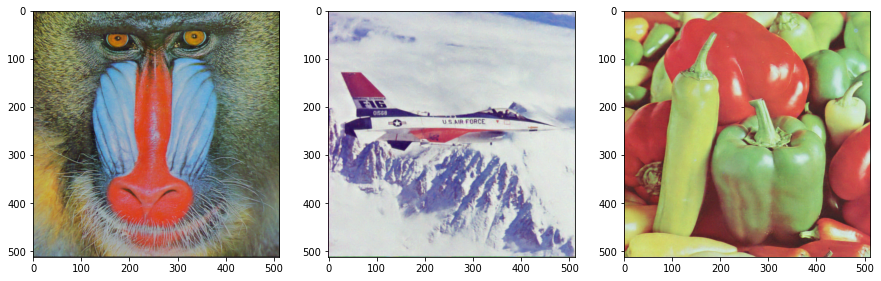

In [22]:
# If "Invalid output shape" is raised, uncomment following commands
pyfftw.interfaces.cache.disable()
pyfftw.interfaces.cache.enable()
pyfftw.interfaces.cache.set_keepalive_time(300)
  
uRec2 = []
for n in range( x.shape[x.ndim-1] ):
    uRec2.append( freqOp.fRec(x[...,n], uLP[...,n] ) )       # uRec = fwOp(x) + uLP

pltImg  = ImgPlot()
pltImg.plotNImgs(uRec2, len(uRec2), None, 5)

## Cost functional

[Text(0.5, 0, 'Time (sec.)')]

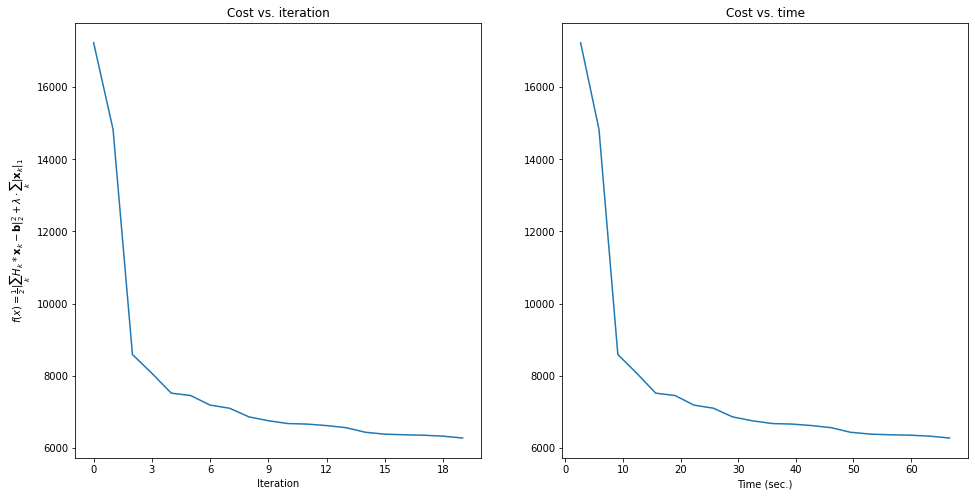

In [23]:
import matplotlib.pylab as PLT
from matplotlib.ticker import MaxNLocator


# Plot cost functional ---
figure, f = PLT.subplots(ncols=2, figsize=(16, 8))
  
f[0].plot(Stats[:,0], label=r'$\alpha_k$ -- {0}'.format(args.ssPolicy.name) )
f[0].set_title('Cost vs. iteration')
f[0].xaxis.set_major_locator(MaxNLocator(integer=True))
  
PLT.setp(f[0], xlabel='Iteration', 
           ylabel=r'$f(x) = \frac{1}{2}\left\| \sum_k H_k * \mathbf{x}_k - \mathbf{b} \right\|_2^2 + \lambda \cdot \sum_k \| \mathbf{x}_k \|_1$')
  
f[1].plot(Stats[:,2], Stats[:,0], label=r'$\alpha_k$ -- {0}'.format(args.ssPolicy.name) )
f[1].set_title('Cost vs. time')
PLT.setp(f[1], xlabel='Time (sec.)') 